In [1]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import joblib
import keras_tuner as kt
import tensorflow.keras.utils as kutils

In [2]:
final_df = None

game_window = 4
mypath = "D:/Repos/Personal/RANDOM"

data = pd.read_csv(f"sports-miner.fbref.csv")

data['date'] = pd.to_datetime(data['date'], dayfirst=True, unit="ms")

home_stats = data[["home_team","away_team","date","stats.possesion_home", "stats.passes_home", "stats.passes_completed_home", "stats.passes_away",
                   'stats.passes_completed_away','stats.fouls_home','stats.corners_home',"stats.score_home","stats.score_away",
                   "stats.cards_yellow_home","stats.cards_red_home","stats.shots_home", "stats.shots_away","stats.shots_on_target_home",
                   "stats.shots_on_target_away","season","league", "odds.B365H", "odds.B365D", "odds.B365A"]].copy()
home_stats.rename(columns={
        'home_team': 'team',
        'away_team': 'opponent',
        'stats.score_home': 'goals_for',
        'stats.score_away': 'goals_against',
        'stats.shots_home': 'shots',
        'stats.shots_away': 'shots_against',
        'stats.shots_on_target_home': 'shots_on_target',
        'stats.shots_on_target_away': 'shots_on_target_against',
        'stats.possesion_home': 'possesion',
        "stats.passes_home": "passes",
        "stats.passes_completed_home": "passes_completed",
        "stats.passes_away": "passes_against",
        "stats.passes_completed_away": "passes_completed_against",
        'stats.corners_home': 'corners',
        'stats.fouls_home': 'fouls',
        'stats.cards_yellow_home': 'yellow_cards',
        'stats.cards_red_home': 'red_cards'
    }, inplace=True)
home_stats['home_away'] = 1
home_stats['diff'] = home_stats['goals_for'] - home_stats['goals_against']
home_stats['result'] = home_stats['diff'].map(lambda x: 0 if x < 0 else (1 if x == 0 else 2))

away_stats = data[["home_team","away_team","date","stats.possesion_away", "stats.passes_home", "stats.passes_completed_home", "stats.passes_away",
                   'stats.passes_completed_away','stats.fouls_away','stats.corners_away',"stats.score_home","stats.score_away",
                   "stats.cards_yellow_away","stats.cards_red_away","stats.shots_home", "stats.shots_away","stats.shots_on_target_home",
                   "stats.shots_on_target_away","season","league", "odds.B365H", "odds.B365D", "odds.B365A"]].copy()
away_stats.rename(columns={
        'home_team': 'opponent',
        'away_team': 'team',
        'stats.score_home': 'goals_against',
        'stats.score_away': 'goals_for',
        'stats.shots_away': 'shots',
        'stats.shots_home': 'shots_against',
        'stats.shots_on_target_away': 'shots_on_target',
        'stats.shots_on_target_home': 'shots_on_target_against',
        'stats.possesion_away': 'possesion',
        "stats.passes_away": "passes",
        "stats.passes_completed_away": "passes_completed",
        "stats.passes_home": "passes_against",
        "stats.passes_completed_home": "passes_completed_against",
        'stats.corners_away': 'corners',
        'stats.fouls_away': 'fouls',
        'stats.cards_yellow_away': 'yellow_cards',
        'stats.cards_red_away': 'red_cards'
    }, inplace=True)
away_stats['home_away'] = 0
away_stats['diff'] = away_stats['goals_for'] - away_stats['goals_against']
away_stats['result'] = away_stats['diff'].map(lambda x: 0 if x < 0 else (1 if x == 0 else 2))

team_stats = pd.concat([home_stats, away_stats], ignore_index=True)

team_stats.dropna() # check this
team_stats.sort_values(by='date', inplace=True)

aggregate_features = ['goals_for', 'goals_against', 'shots', 'shots_on_target', 'possesion', 'passes', 'passes_completed', 'corners', 'fouls', 'yellow_cards',
                      'red_cards', 'result', 'shots_on_target_against', "passes_against", "passes_completed_against" ]

processed_seasons = []

def compute_rolling_results(grp, window):
    grp = grp.sort_values(by='date')
    # Shift the values so that the current game is not included
    shifted_home = grp['home_away'].shift()
    shifted_diff = grp['diff'].shift()
    
    # Compute wins using the custom conditions:
    # For home games (home_away == 1): win if diff > 0
    # For away games (home_away == 0): win if diff > 0
    wins = (((shifted_home == 1) & (shifted_diff > 0)) |
            ((shifted_home == 0) & (shifted_diff > 0))).astype(int)
    
    # Draws: when diff == 0 (for both home and away)
    draws = (shifted_diff == 0).astype(int)
    
    # Losses:
    # For home games: loss if diff < 0
    # For away games: loss if diff < 0
    losses = (((shifted_home == 1) & (shifted_diff < 0)) |
              ((shifted_home == 0) & (shifted_diff < 0))).astype(int)
    
    grp['past_games_wins'] = wins.rolling(window=window, min_periods=1).sum()
    grp['past_games_draws'] = draws.rolling(window=window, min_periods=1).sum()
    grp['past_games_losses'] = losses.rolling(window=window, min_periods=1).sum()
    
    return grp

for season in team_stats['season'].unique():
    season_data = team_stats[team_stats['season'] == season].copy()
    
    # Apply rolling calculation for each feature
    for feature in aggregate_features:
        season_data[feature] = (
            season_data.groupby('team')[feature]
            .transform(lambda x: x.shift().rolling(window=game_window, min_periods=game_window).mean())
        )
    season_data = season_data.groupby('team').apply(lambda grp: compute_rolling_results(grp, game_window))
    
    processed_seasons.append(season_data)

team_stats = pd.concat(processed_seasons, ignore_index=True)

team_stats = team_stats.dropna()
df = team_stats

home_df = df[df['home_away'] == 1].copy()
away_df = df[df['home_away'] == 0].copy()

home_df = home_df.rename(lambda x: x + '_home' if x not in ['season', 'league', 'date', 'team', 'opponent', "odds.B365H", "odds.B365D", "odds.B365A"] else x, axis=1)
away_df = away_df.rename(lambda x: x + '_away' if x not in ['season', 'league', 'date', 'team', 'opponent', "odds.B365H", "odds.B365D", "odds.B365A"] else x, axis=1)
final_df = pd.merge(
        home_df,
        away_df,
        left_on=['season', 'league', 'date', 'team', 'opponent', "odds.B365H", "odds.B365D", "odds.B365A"],
        right_on=['season', 'league', 'date', 'opponent', 'team', "odds.B365H", "odds.B365D", "odds.B365A"],
        suffixes=('_home', '_away')
)
final_df['target'] = final_df['diff_home'].map(lambda x: 0 if x < 0 else (1 if x == 0 else 2))
final_df.sort_values('date', inplace=True)

C:\Users\ghera\AppData\Local\Temp\ipykernel_20964\2625466291.py:110: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  season_data = season_data.groupby('team').apply(lambda grp: compute_rolling_results(grp, game_window))
C:\Users\ghera\AppData\Local\Temp\ipykernel_20964\2625466291.py:110: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  season_data = season_data.groupby('team').apply(lambda grp: compute_rolling_r

In [3]:
# Passes rates
final_df['passes_rate_home'] = np.where(
   final_df["passes_home"] == 0, 
   0, 
   final_df["passes_completed_home"] / final_df["passes_home"]
)
final_df['passes_rate_away'] = np.where(
   final_df["passes_away"] == 0, 
   0, 
   final_df["passes_completed_away"] / final_df["passes_away"]
)
final_df['passes_rate_against_home'] = np.where(
   final_df["passes_against_home"] == 0, 
   0, 
   final_df["passes_completed_against_home"] / final_df["passes_against_home"]
)
final_df['passes_rate_against_away'] = np.where(
   final_df["passes_against_away"] == 0, 
   0, 
   final_df["passes_completed_against_away"] / final_df["passes_against_away"]
)

# Shots rates
final_df['shots_rate_home'] = np.where(
   final_df["shots_home"] == 0, 
   0, 
   final_df["shots_on_target_home"] / final_df["shots_home"]
)
final_df['shots_rate_away'] = np.where(
   final_df["shots_away"] == 0, 
   0, 
   final_df["shots_on_target_away"] / final_df["shots_away"]
)
final_df['shots_rate_against_home'] = np.where(
   final_df["shots_against_home"] == 0, 
   0, 
   final_df["shots_on_target_against_home"] / final_df["shots_against_home"]
)
final_df['shots_rate_against_away'] = np.where(
   final_df["shots_against_away"] == 0, 
   0, 
   final_df["shots_on_target_against_away"] / final_df["shots_against_away"]
)

final_df['cards_home'] = final_df['yellow_cards_home'] + 3 * final_df["red_cards_home"]
final_df['cards_away'] = final_df['yellow_cards_away'] + 3 * final_df["red_cards_away"]

In [4]:
feature_columns = ['goals_for_home', 'goals_against_home',
                           'shots_home', 'shots_on_target_home',
                           'shots_against_home' ,'shots_on_target_against_home',
                           # "shots_rate_home", "shots_rate_against_home",
                           # 'passes_home', 
                           # "passes_against_home",
                           'passes_completed_home',
                           "passes_completed_against_home",
                           # "passes_rate_home", "passes_rate_against_home",
                           'possesion_home',
                           # 'corners_home', 'fouls_home',
                           # "cards_home",
                           "past_games_losses_home", "past_games_draws_home", "past_games_wins_home",
                           # 'result_home',
                           'goals_for_away', 'goals_against_away',
                           'shots_away', 'shots_on_target_away',
                           'shots_against_away', 'shots_on_target_against_away', 
                           # "shots_rate_away", "shots_rate_against_away",
                           # 'passes_away',
                           # "passes_against_away",
                           'passes_completed_away',
                           "passes_completed_against_away", 
                           # "passes_rate_away", "passes_rate_against_away",
                           'possesion_away',
                           # 'corners_away', 'fouls_away',
                           # "cards_away",
                           "past_games_losses_away", "past_games_draws_away", "past_games_wins_away"
                           # 'result_away'
                  ]
# feature_columns.extend(['yellow_cards_home', 'red_cards_home', 'yellow_cards_away', 'red_cards_away'])

scaler = MinMaxScaler()
scaler.fit(final_df[feature_columns])
to_split = final_df[feature_columns]
to_split = scaler.transform(final_df[feature_columns])

X_train, X_test, y_train, y_test = train_test_split(to_split, final_df[[ "odds.B365H", "odds.B365D", "odds.B365A", 'target']], test_size=0.10, random_state=42)

print(X_train.shape)
print(X_test.shape)
print("A: " + str(len(final_df.loc[final_df['target'] == 0])))
print("D: " + str(len(final_df.loc[final_df['target'] == 1])))
print("H: " + str(len(final_df.loc[final_df['target'] == 2])))

(12147, 24)
(1350, 24)
A: 4105
D: 3376
H: 6016


In [5]:
final_df[["team_home", "opponent_home", "date", "possesion_home", "possesion_away",
          "past_games_wins_home", "past_games_draws_home", "past_games_losses_home",
         "past_games_wins_away", "past_games_draws_away", "past_games_losses_away",
         "target"]].head()

,team_home,opponent_home,date,possesion_home,possesion_away,past_games_wins_home,past_games_draws_home,past_games_losses_home,past_games_wins_away,past_games_draws_away,past_games_losses_away,target
17,Aston Villa,Arsenal,2014-09-19 21:00:00,36.75,60.75,3.0,1.0,0.0,1.0,3.0,0.0,0
34,Burnley,Sunderland,2014-09-19 21:00:00,43.75,46.25,0.0,2.0,2.0,0.0,3.0,1.0,1
272,Swansea City,Southampton,2014-09-19 21:00:00,49.00,54.00,3.0,0.0,1.0,2.0,1.0,1.0,0
323,West Ham United,Liverpool,2014-09-19 21:00:00,49.00,54.50,1.0,1.0,2.0,2.0,0.0,2.0,2
204,Queens Park Rangers,Stoke City,2014-09-19 21:00:00,39.50,51.75,1.0,0.0,3.0,1.0,1.0,2.0,1


In [6]:
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(final_df['target']),
                                     y=final_df['target'])

class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Computed class_weight_dict:", class_weight_dict)

rf_model = RandomForestClassifier(
    n_estimators=250,          # Increase number of trees
    max_depth=20,              # Slightly deeper trees
    min_samples_split=10,       # More flexible splitting
    min_samples_leaf=10,        # More flexible leaves
    max_features='sqrt',       # Common choice to reduce correlation
    class_weight=class_weight_dict,
    n_jobs=-1,
    random_state=10
)

hgb_model = HistGradientBoostingClassifier(
    max_iter=400,               # More boosting iterations
    max_depth=15,               # Reasonably deep
    learning_rate=0.03,         # Slightly smaller LR
    # min_samples_leaf=5,         # Controls overfitting
    # l2_regularization=1.0,      # Regularization to reduce overfit
    early_stopping=True,
    scoring='balanced_accuracy',# Makes sense in imbalanced data
    random_state=10
)

cat_model = CatBoostClassifier(
    iterations=500,            # More iterations
    # depth=8,                   # Controls model complexity
    learning_rate=0.03,        # Slightly smaller LR
    # l2_leaf_reg=3,             # L2 regularization
    # border_count=128,          # Number of splits for numerical features
    loss_function='MultiClass',
    eval_metric='MultiClass',
    auto_class_weights='Balanced',  # Let CatBoost internally handle imbalance
    early_stopping_rounds=50,
    random_state=10,
    verbose=0
)

xgb_model = XGBClassifier(
    n_estimators=350,          # More boosting rounds
    max_depth=15,               # Deeper trees
    min_child_weight=3,        # Further control overfitting
    learning_rate=0.03,        # Smaller learning rate
    # colsample_bytree=0.9,      # Subsample features
    # subsample=0.8,             # Subsample rows
    objective='multi:softprob',# Probability outputs
    num_class=len(np.unique(y_train['target'])),
    eval_metric='mlogloss',
    use_label_encoder=False,   # Avoid label encoder warnings
    n_jobs=-1,
    random_state=10
)

mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 256, 64),   # A common multi-layer architecture
    activation='relu',
    solver='adam',
    alpha=1e-4,                          # L2 regularization
    # learning_rate='adaptive',            # Adjust LR if not improving, only for solver='sgd'
    learning_rate_init=1e-3,
    max_iter=500,                        # More epochs
    batch_size=64,                       # Smaller batch size can help generalization
    early_stopping=True,                 # Stops when validation score isn't improving
    warm_start=True,
    # class_weight='balanced',             # Handle imbalance in MLP
    random_state=10,
    verbose=False
)

rf_model.fit(X_train, y_train['target'])
# hgb_model.fit(X_train, y_train['target'])
cat_model.fit(X_train, y_train['target'])
xgb_model.fit(X_train, y_train['target'])
# mlp_model.fit(X_train, y_train['target'])

y_pred_rf  = rf_model.predict(X_test)
# y_pred_hgb = hgb_model.predict(X_test)
y_pred_cat = cat_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)
# y_pred_mlp = mlp_model.predict(X_test)

def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    print(classification_report(y_true, y_pred, target_names=['Away Win', 'Draw', 'Home Win']))

evaluate_model('Random Forest', y_test['target'], y_pred_rf)
# evaluate_model('HistGradientBoosting', y_test['target'], y_pred_hgb)
evaluate_model('CatBoost', y_test['target'], y_pred_cat)
evaluate_model('XGBoost', y_test['target'], y_pred_xgb)
# evaluate_model('MLP Classifier', y_test['target'], y_pred_mlp)

# Classification Report
# print('Classification Report:')
# print(classification_report(y_test, y_pred, target_names=['Loss', 'Draw', 'Win']))

Computed class_weight_dict: {0: 1.0959805115712546, 1: 1.3326421800947867, 2: 0.7478390957446809}


C:\Users\ghera\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:24:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Random Forest Performance:
Accuracy: 0.4896
Balanced Accuracy: 0.4542
              precision    recall  f1-score   support

    Away Win       0.47      0.53      0.49       415
        Draw       0.32      0.24      0.28       320
    Home Win       0.57      0.59      0.58       615

    accuracy                           0.49      1350
   macro avg       0.45      0.45      0.45      1350
weighted avg       0.48      0.49      0.48      1350


CatBoost Performance:
Accuracy: 0.4911
Balanced Accuracy: 0.4688
              precision    recall  f1-score   support

    Away Win       0.47      0.54      0.50       415
        Draw       0.31      0.32      0.31       320
    Home Win       0.62      0.55      0.58       615

    accuracy                           0.49      1350
   macro avg       0.47      0.47      0.47      1350
weighted avg       0.50      0.49      0.49      1350


XGBoost Performance:
Accuracy: 0.4904
Balanced Accuracy: 0.4230
              precision    recall  f

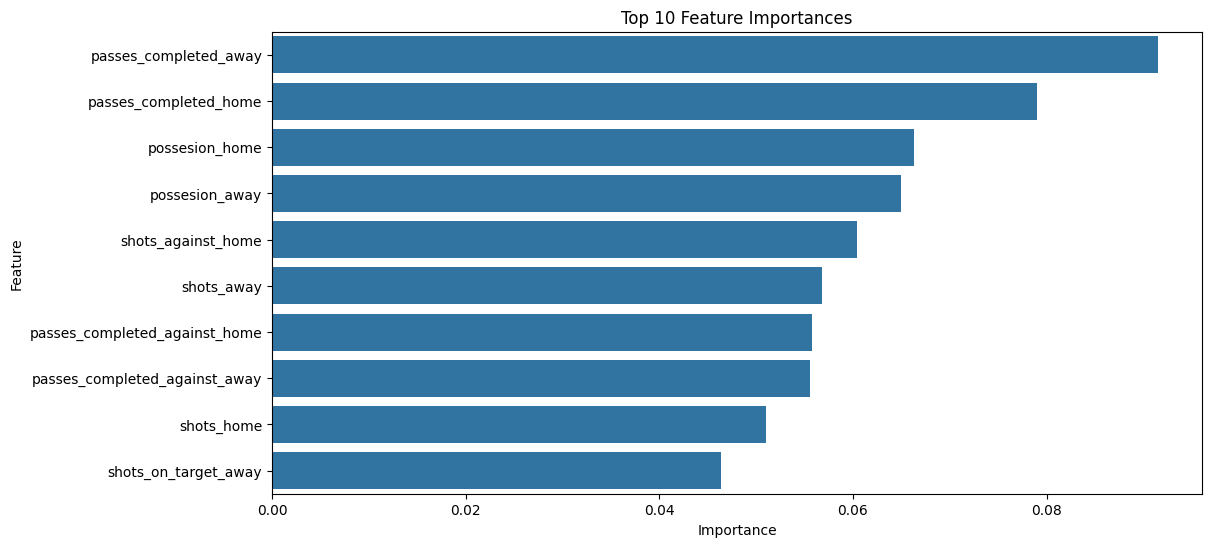

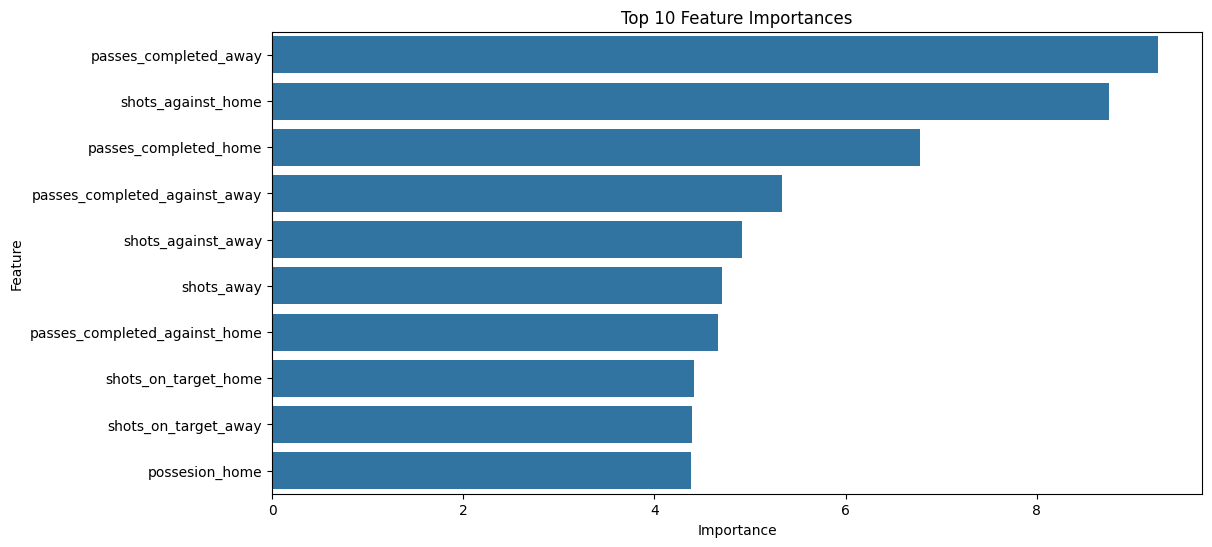

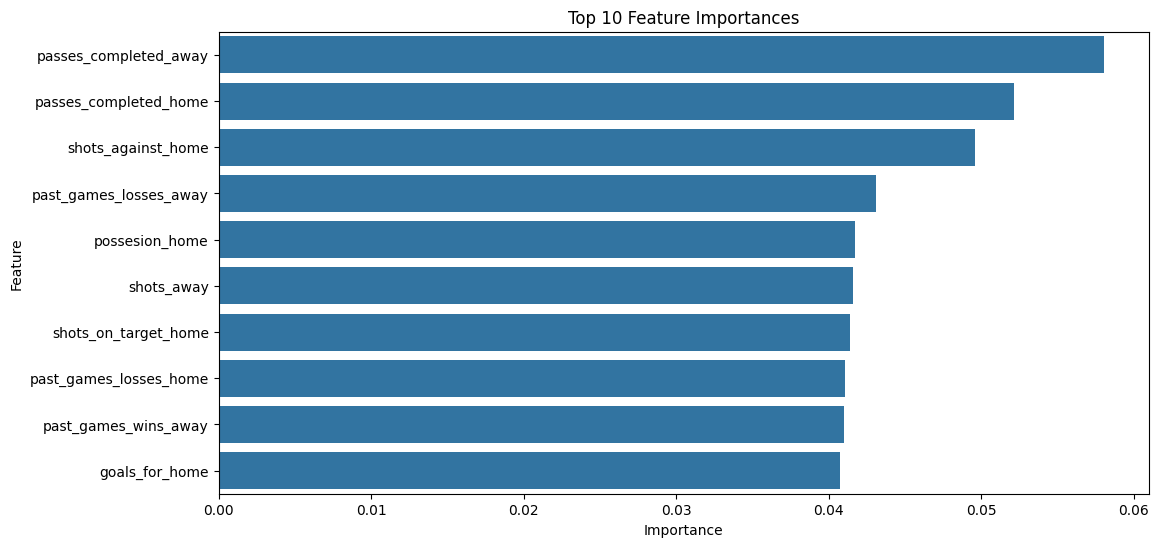

In [7]:
# cm = confusion_matrix(y_test, y_pred)

# plt.figure(figsize=(8,6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Loss', 'Draw', 'Win'], yticklabels=['Loss', 'Draw', 'Win'])
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.title('Confusion Matrix')
# plt.show()

importances = [rf_model.feature_importances_, cat_model.feature_importances_, xgb_model.feature_importances_]
feature_names = feature_columns

for elem in importances:
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': elem
    }).sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(12,6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
    plt.title('Top 10 Feature Importances')
    plt.show()

In [8]:
def validate_with_odds(X_test, y_test, min_score = [0.5, 0.4, 0.5]):
    total = {
        "A": 0,
        "D": 0,
        "H": 0
    }
    correct = {
        "A": 0,
        "D": 0,
        "H": 0
    }
    p1_count = 0
    p2_count = 0
    
    selected_info = {
        "A": [],
        "D": [],
        "H": []
    }
    odds = {
        "A": 0,
        "D": 0,
        "H": 0
    }
    X_test = np.array(X_test)
    for row_i in range(0,len(X_test)):
        x_sample = X_test[row_i].reshape(1, -1)
        y2_probs = model.predict(x_sample, verbose=0)
        
        pred2 = np.argmax(y2_probs, axis=1)[0]
    
        if pred2 == 0:
            if y2_probs[0][0] > min_score[0]:
                total["A"] += 1
                info = final_df.loc[row_i, ["team_home","opponent_home", "date", "target"]]
                selected_info["A"].append(info)
                if y_test.iloc[row_i]['target'] == 0:
                    correct["A"] += 1
                    odds["A"] += y_test.iloc[row_i]['odds.B365A']
        elif pred2 == 1:
            if y2_probs[0][1] > min_score[1]:
                total["D"] += 1
                info = final_df.loc[row_i, ["team_home","opponent_home", "date", "target"]]
                selected_info["D"].append(info)
                if y_test.iloc[row_i]['target'] == 1:
                    correct["D"] += 1
                    odds["D"] += y_test.iloc[row_i]['odds.B365D']
        else:
            if y2_probs[0][2] > min_score[2]:
                total["H"] += 1
                info = final_df.loc[row_i, ["team_home","opponent_home", "date", "target"]]
                selected_info["H"].append(info)
                if y_test.iloc[row_i]['target'] == 2:
                    correct["H"] += 1
                    odds["H"] += y_test.iloc[row_i]['odds.B365H']
    
    final_win = 0
    final_total = 0
    for key in odds.keys():
        print("-------------------")
        print("Total count:", total[key])
        print("Correct count:", correct[key])
        if (total[key] == 0):
            continue
        print("Prediction %:", correct[key] / total[key])
        print("Total odd won: ", odds[key] - total[key])
        print("Expected win per game: ", (odds[key] - total[key]) / total[key])
        final_win += odds[key] - total[key]
        final_total += total[key]
    print("----------FINAL---------")
    print("Total odd won: ", final_win)
    print("Expected win per game: ", final_win / final_total )
    print("Percentage of games: ", final_total / len(y_test))
    
    # selected_df = pd.DataFrame(selected_info)
    # print("Selected rows from final_df (team, opponent, season):")
    # print(selected_df)

In [9]:
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(final_df['target']),
                                     y=final_df['target'])

class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

def build_model(hp):
    model = Sequential()

    # Define the input shape explicitly using the Input layer
    model.add(Input(shape=(X_train.shape[1],)))
    
    # First hidden layer: tune number of units and dropout rate
    model.add(Dense(units=hp.Int('units_1', min_value=64, max_value=512, step=32),
                    activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Second hidden layer: tune number of units and dropout rate
    model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=384, step=32),
                    activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))

    # Second hidden layer: tune number of units and dropout rate
    model.add(Dense(units=hp.Int('units_3', min_value=16, max_value=256, step=32),
                    activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Output layer for 3-class classification
    model.add(Dense(3, activation='softmax'))
    
    # Tune learning rate for the Adam optimizer
    model.compile(optimizer=Adam(learning_rate=hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create a Hyperband tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=40,
    factor=3,
    directory='my_dir',  # Directory to store tuning results
    project_name='pred_24'
)

# Early stopping callback to avoid overtraining
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Run the hyperparameter search
tuner.search(X_train, kutils.to_categorical(y_train['target']), epochs=50, validation_split=0.155, callbacks=[stop_early], class_weight = class_weight_dict)

# Retrieve the best model found during the search
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(best_hyperparameters.values)

Reloading Tuner from my_dir\pred_24\tuner0.json

Best Hyperparameters:
{'units_1': 384, 'dropout_1': 0.30000000000000004, 'units_2': 128, 'dropout_2': 0.4, 'units_3': 112, 'dropout_3': 0.30000000000000004, 'lr': 0.004951482220278488, 'tuner/epochs': 40, 'tuner/initial_epoch': 14, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0077'}


C:\Users\ghera\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ghera\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [9]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train['target']), y=y_train['target'])
# class_weights = compute_class_weight(class_weight='balanced',
#                                      classes=np.unique(final_df['target']),
#                                      y=final_df['target'])
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

num_classes = len(np.unique(y_train['target']))
y_train_encoded = keras.utils.to_categorical(y_train['target'], num_classes)
y_test_encoded = keras.utils.to_categorical(y_test['target'], num_classes)

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer
    BatchNormalization(),
    Dropout(0.3),  # Regularization

    Dense(128, activation='relu'),  # Hidden layer 1
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),  # Hidden layer 2
    BatchNormalization(),
    Dropout(0.2),

    Dense(num_classes, activation='softmax')  # Output layer for multi-class classification
])

model.compile(
    optimizer=Adam(learning_rate=0.005),  # Adam optimizer with learning rate
    loss='categorical_crossentropy',  # Suitable for multi-class classification
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train_encoded,
    validation_split=0.1,
    epochs=50,  # Start with 50 epochs, can tune later
    batch_size=64,  # Can be adjusted based on performance
    class_weight=class_weight_dict,  # Handling class imbalance
    verbose=0
)

test_loss, test_acc = model.evaluate(X_test, y_test_encoded, verbose=1)
print(f"\nTest Accuracy: {test_acc:.4f}")

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_test['target'], y_pred, target_names=['Loss', 'Draw', 'Win']))
# validate_with_odds(X_test, y_test)

C:\Users\ghera\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - accuracy: 0.4730 - loss: 1.0388

Test Accuracy: 0.4681
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

        Loss       0.47      0.44      0.46       415
        Draw       0.28      0.36      0.32       320
         Win       0.60      0.54      0.57       615

    accuracy                           0.47      1350
   macro avg       0.45      0.45      0.45      1350
weighted avg       0.48      0.47      0.47      1350



In [10]:
model = best_model

In [11]:
print("Loss: " + str(len(y_test.loc[y_test['target'] == 0])))
print("Draw: " + str(len(y_test.loc[y_test['target'] == 1])))
print("Win: " + str(len(y_test.loc[y_test['target'] == 2])))

Loss: 415
Draw: 320
Win: 615


In [12]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
print(classification_report(y_test['target'], y_pred, target_names=['Loss', 'Draw', 'Win']))
y_train_encoded = keras.utils.to_categorical(y_train['target'], 3)
y_test_encoded = keras.utils.to_categorical(y_test['target'], 3)
test_loss, test_acc = model.evaluate(X_test, y_test_encoded, verbose=1)
print(f"\nTest Accuracy: {test_acc:.4f}")
validate_with_odds(X_test, y_test, [0.53, 0.38, 0.55])

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

        Loss       0.48      0.50      0.49       415
        Draw       0.25      0.10      0.14       320
         Win       0.55      0.71      0.62       615

    accuracy                           0.50      1350
   macro avg       0.43      0.44      0.42      1350
weighted avg       0.46      0.50      0.47      1350

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5061 - loss: 1.0148  

Test Accuracy: 0.5030
-------------------
Total count: 144
Correct count: 77
Prediction %: 0.5347222222222222
Total odd won:  -20.43000000000002
Expected win per game:  -0.14187500000000014
-------------------
Total count: 59
Correct count: 17
Prediction %: 0.288135593220339
Total odd won:  0.4299999999999997
Expected win per game:  0.007288135593220334
-------------------
Total count: 313
Correct count: 210
Prediction %: 0.670926517571885
Total odd won:  -13.200000000000045
Expected win per game:  

In [36]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
print(classification_report(y_test['target'], y_pred, target_names=['Loss', 'Draw', 'Win']))
y_train_encoded = keras.utils.to_categorical(y_train['target'], 3)
y_test_encoded = keras.utils.to_categorical(y_test['target'], 3)
test_loss, test_acc = model.evaluate(X_test, y_test_encoded, verbose=1)
print(f"\nTest Accuracy: {test_acc:.4f}")
validate_with_odds(X_test, y_test, [0.55, 0.42, 0.53])

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
              precision    recall  f1-score   support

        Loss       0.43      0.59      0.50       415
        Draw       0.27      0.34      0.30       320
         Win       0.65      0.41      0.50       615

    accuracy                           0.45      1350
   macro avg       0.45      0.44      0.43      1350
weighted avg       0.49      0.45      0.45      1350

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - accuracy: 0.4401 - loss: 1.0641

Test Accuracy: 0.4474
-------------------
Total count: 249
Correct count: 130
Prediction %: 0.5220883534136547
Total odd won:  -0.7399999999999523
Expected win per game:  -0.0029718875502006115
-------------------
Total count: 165
Correct count: 48
Prediction %: 0.2909090909090909
Total odd won:  1.5300000000000296
Expected win per game:  0.009272727272727451
-------------------
Total count: 135
Correct count: 97
Prediction %: 0.7185185185185186
Total odd won:  -10.030000000000001
Expected win per 

In [14]:
best_model.save('./checkpoints/best_model_24.keras')

In [11]:
model = tf.keras.models.load_model('./checkpoints/best_model_03_29_515.keras')
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
print(classification_report(y_test['target'], y_pred, target_names=['Loss', 'Draw', 'Win']))
y_train_encoded = keras.utils.to_categorical(y_train['target'], 3)
y_test_encoded = keras.utils.to_categorical(y_test['target'], 3)
test_loss, test_acc = model.evaluate(X_test, y_test_encoded, verbose=1)
print(f"\nTest Accuracy: {test_acc:.4f}")
validate_with_odds(X_test, y_test, [0.75, 0.38, 0.5])

 1/43 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step

C:\Users\ghera\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

        Loss       0.49      0.49      0.49       415
        Draw       0.26      0.12      0.16       320
         Win       0.56      0.71      0.63       615

    accuracy                           0.50      1350
   macro avg       0.43      0.44      0.43      1350
weighted avg       0.47      0.50      0.48      1350

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - accuracy: 0.5127 - loss: 1.0144

Test Accuracy: 0.5044
-------------------
Total count: 0
Correct count: 0
-------------------
Total count: 11
Correct count: 1
Prediction %: 0.09090909090909091
Total odd won:  -7.9
Expected win per game:  -0.7181818181818183
-------------------
Total count: 350
Correct count: 230
Prediction %: 0.6571428571428571
Total odd won:  -15.930000000000064
Expected win per game:  -0.045514285714285896
----------FINAL---------
Total odd won:  -23.830000000000062
Expected win per game:  -0.06601108033241014
P

In [13]:
joblib.dump(scaler, 'checkpoints/saved_scaler.pkl')

['checkpoints/saved_scaler.pkl']